In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from IPython.display import Image
from IPython.core.display import HTML
import scipy.integrate
import math

%matplotlib notebook

In [5]:
m = Symbol("m") # Total mass of the Robot including Legs (combined into point mass)
g_constant = Symbol("g") # Gravity acceleration constant used in g-vector
g = Matrix([0, 0, -g_constant])

In [3]:
# Symbols for inertia tensor of the point mass

Ixx, Ixy, Ixz = symbols("Ixx Ixy Ixz")
Iyx, Iyy, Iyz = symbols("Iyx Iyy Iyz")
Izx, Izy, Izz = symbols("Izx Izy Izz")

# Inertia Tensor of the Robot (as a point mass) in body frame coordinates.
# This should include Torso and Legs in zero configuration

I_body = Matrix([[Ixx, Ixy, Ixz],
                [Iyx, Iyy, Iyz],
                [Izx, Ixy, Izz]])

I_body

Matrix([
[Ixx, Ixy, Ixz],
[Iyx, Iyy, Iyz],
[Izx, Ixy, Izz]])

In [4]:
f_x_l, f_y_l, f_z_l = symbols("f_x_l f_y_l f_z_l") # Symbols for left reaction force vector

f_l = Matrix([f_x_l, f_y_l, f_z_l])  # 3x1 Reaction force vector of the left leg

f_l

Matrix([
[f_x_l],
[f_y_l],
[f_z_l]])

In [5]:
f_x_r, f_y_r, f_z_r = symbols("f_x_r f_y_r f_z_r") # Symbols for right reaction force vector

f_r = Matrix([f_x_r, f_y_r, f_z_r])  # 3x1 Reaction force vector of the right leg

f_r

Matrix([
[f_x_r],
[f_y_r],
[f_z_r]])

In [6]:
# Explanation for Rigid Body Dynamics of a point mass:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_I_-_Mechanics%2C_Sound%2C_Oscillations%2C_and_Waves_(OpenStax)/10%3A_Fixed-Axis_Rotation__Introduction/10.08%3A_Newton%E2%80%99s_Second_Law_for_Rotation

In [7]:
phi, theta, psi = symbols("phi theta psi") # Euler angles of the point mass used for orientation
phi_dot, theta_dot, psi_dot = symbols("phidot thetadot psidot") # Derivatives of Euler angles of the point mass

omega_x, omega_y, omega_z = symbols("omega_x omega_y omega_z") # Angular velocity of point mass in X-Y-Z

omega = Matrix([omega_x, omega_y, omega_z]) # 3x1 vector describing angular velocity of the point mass

omega

Matrix([
[omega_x],
[omega_y],
[omega_z]])

In [8]:
# Converting 3x1 vector to 3x3 skew symmetric matrix based on: 
# https://math.stackexchange.com/questions/2248413/skew-symmetric-matrix-of-vector
# See also: https://en.wikipedia.org/wiki/Skew-symmetric_matrix
Image(url="https://cdn.discordapp.com/attachments/680811067848655093/689769467890368541/unknown.png")

In [9]:
omega_skew_symmetric = Matrix([[0, -omega.row(2)[0], omega.row(1)[0]],
                               [omega.row(2)[0], 0, -omega.row(0)[0]],
                               [-omega.row(1)[0], omega.row(0)[0], 0]])
omega_skew_symmetric

Matrix([
[       0, -omega_z,  omega_y],
[ omega_z,        0, -omega_x],
[-omega_y,  omega_x,        0]])

In [10]:
r_x_l, r_y_l, r_z_l = symbols("r_x_l r_y_l r_z_l")
r_l = Matrix([r_x_l, r_y_l, r_z_l]) # Location of left foot ground reaction force

r_l

Matrix([
[r_x_l],
[r_y_l],
[r_z_l]])

In [11]:
r_l_skew_symmetric = Matrix([[0, -r_l.row(2)[0], r_l.row(1)[0]],
                             [r_l.row(2)[0], 0, -r_l.row(0)[0]],
                             [-r_l.row(1)[0], r_l.row(0)[0], 0]])
r_l_skew_symmetric

Matrix([
[     0, -r_z_l,  r_y_l],
[ r_z_l,      0, -r_x_l],
[-r_y_l,  r_x_l,      0]])

In [12]:
r_x_r, r_y_r, r_z_r = symbols("r_x_r r_y_r r_z_r")
r_r = Matrix([r_x_r, r_y_r, r_z_r]) # Location of right foot ground reaction force

r_r

Matrix([
[r_x_r],
[r_y_r],
[r_z_r]])

In [13]:
r_r_skew_symmetric = Matrix([[0, -r_r.row(2)[0], r_r.row(1)[0]],
                             [r_r.row(2)[0], 0, -r_r.row(0)[0]],
                             [-r_r.row(1)[0], r_r.row(0)[0], 0]])
r_r_skew_symmetric

Matrix([
[     0, -r_z_r,  r_y_r],
[ r_z_r,      0, -r_x_r],
[-r_y_r,  r_x_r,      0]])

In [14]:
R_z = Matrix([[cos(psi), -sin(psi), 0],
              [sin(psi), cos(psi), 0],
              [0, 0, 1]])

R_y = Matrix([[cos(theta), 0, sin(theta)],
              [0, 1, 0],
              [-sin(theta), 0, cos(theta)]])

R_x = Matrix([[1, 0, 0],
              [0, cos(phi), -sin(phi)],
              [0, sin(phi), cos(phi)]])

R = R_z * R_y * R_x # Rotation matrix from Body frame to World frame based on Z-Y-X Rotation order

R = R.inv() # Invert matrix as the angular velocity of the point mass is omega_world = R * omega_body ("omega" in the notebook)
R = simplify(R.subs({phi:0, theta:0})) # Omit roll and pitch of the point mass because they should be very small.

R # will be identical to R_z

Matrix([
[ cos(psi), sin(psi), 0],
[-sin(psi), cos(psi), 0],
[        0,        0, 1]])

In [15]:
I_world = R * I_body * R.T # Transform / Rotate body inertia tensor into the world coordinate frame

I_world

Matrix([
[  (Ixx*cos(psi) + Iyx*sin(psi))*cos(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*sin(psi),   -(Ixx*cos(psi) + Iyx*sin(psi))*sin(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*cos(psi),  Ixz*cos(psi) + Iyz*sin(psi)],
[(-Ixx*sin(psi) + Iyx*cos(psi))*cos(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*sin(psi), -(-Ixx*sin(psi) + Iyx*cos(psi))*sin(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*cos(psi), -Ixz*sin(psi) + Iyz*cos(psi)],
[                                                      Ixy*sin(psi) + Izx*cos(psi),                                                        Ixy*cos(psi) - Izx*sin(psi),                          Izz]])

In [16]:
# Define symbols for state space model
# delta is CoM orientation, p_hat is world position, omega_hat is world angular velocity,
# p_dot_hat is world cartesian velocity
delta, p_hat, omega_hat, p_dot_hat = symbols("delta phat omegahat pdothat")

#Continuous-time 13x13 matrix (12 for the 4 4x1 state vectors 
# + 1 row for the added gravity term to get State-Space Form

A_c = Matrix([[0, 0, 0, 0, 0, 0, R.col(0)[0], R.col(1)[0], R.col(2)[0], 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, R.col(0)[1], R.col(1)[1], R.col(2)[1], 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, R.col(0)[2], R.col(1)[2], R.col(2)[2], 0, 0, 0, 0],
              
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

print("A_c shape:", A_c.shape)

A_c

A_c shape: (13, 13)


Matrix([
[0, 0, 0, 0, 0, 0,  cos(psi), sin(psi), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, -sin(psi), cos(psi), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,         0,        0, 0, 0, 0, 0, 1]])

(2003,)


<IPython.core.display.Javascript object>


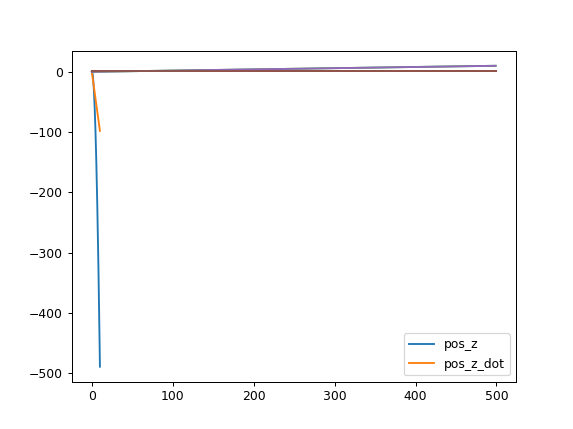

In [6]:
I_world = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])

r_left = np.array([[0, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
    
r_right = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]])
    
f_left = np.array([[0],
                   [0],
                   [0]])
    
f_right = np.array([[0],
                    [0],
                    [0]])

m_value = 30 # kg

x0 = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -9.81]

def func(t, x):
    #print("t:", t)
    #print(x)
    
    x_t = np.array(x).reshape(13,1)
    
    I_world = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]]) # Inertia in the world frame. See symbolic definiton with rotation matrix from body frame above.

    # Location of the force vector being applied by the left foot.
    r_x_left = 0.1
    r_y_left = 0
    r_z_left = 0

    # Location of the force vector being applied by the right foot.
    r_x_right = -0.1
    r_y_right = 0
    r_z_right = 0


    # Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                  [r_z_left, 0, -r_x_left],
                                  [-r_y_left, r_x_left, 0]]) 
    
    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                   [r_z_right, 0, -r_x_right],
                                   [-r_y_right, r_x_right, 0]]) 

    A_c_temp = np.array([[0, 0, 0, 0, 0, 0, math.cos(x_t[2]), math.sin(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(x_t[2]), math.cos(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

    B_c_temp = np.block([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [I_world @ r_left_skew_symmetric, I_world @ r_right_skew_symmetric],
                [1/m_value, 0, 0, 1/m_value, 0, 0],
                [0, 1/m_value, 0, 0, 1/m_value, 0],
                [0, 0, 1/m_value, 0, 0, 1/m_value],
                [0, 0, 0, 0, 0, 0]])
    
    A_t = np.array([[0, 0, 0, 0, 0, 0, math.cos(x_t[2]), math.sin(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(x_t[2]), math.cos(x_t[2]), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    temp_l = np.linalg.inv(I_world).dot(r_left)

    temp_r = np.linalg.inv(I_world).dot(r_right)

    B_t = np.array([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [temp_l[0][0], temp_l[0][1], temp_l[0][2], temp_r[0][0], temp_r[0][1], temp_r[0][2]],
                    [temp_l[1][0], temp_l[1][1], temp_l[1][2], temp_r[1][0], temp_r[1][1], temp_r[1][2]],
                    [temp_l[2][0], temp_l[2][1], temp_l[2][2], temp_r[2][0], temp_r[2][1], temp_r[2][2]],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])
    
    u_t = np.array(np.array([[f_left[0][0]],
                             [f_left[1][0]],
                             [f_left[2][0]],
                             [f_right[0][0]],
                             [f_right[1][0]],
                             [f_right[2][0]]]))
    
    #print(B_t == B_c_temp)

    
    x_dot_t = A_t.dot(x_t) #+ B_t.dot(u_t)
    #print(x_dot_t.shape)
    #print(x_dot_t[0])
    
    return [x_dot_t[0][0], x_dot_t[1][0], x_dot_t[2][0], x_dot_t[3][0], x_dot_t[4][0], x_dot_t[5][0], x_dot_t[6][0], x_dot_t[7][0], x_dot_t[8][0], x_dot_t[9][0], x_dot_t[10][0], x_dot_t[11][0], x_dot_t[12][0]]


#func(0,x0)
#print("Test ran")

solution = scipy.integrate.solve_ivp(func, [0, 10], x0, max_step=.005) # , atol=0.0015, rtol=0.0015

print(solution.y[0].shape)

fig = plt.figure()
ax = fig.add_subplot(111)


#ax.plot(solution.t, solution.y[0],label="roll")
#ax.plot(solution.t, solution.y[1],label="pitch")
#ax.plot(solution.t, solution.y[2],label="yaw")
#ax.plot(solution.t, solution.y[3],label="pos_x")
#ax.plot(solution.t, solution.y[4],label="pos_y")
ax.plot(solution.t, solution.y[5],label="pos_z")
#ax.plot(solution.t, solution.y[6],label="omega_x")
#ax.plot(solution.t, solution.y[7],label="omega_y")
#ax.plot(solution.t, solution.y[8],label="omega_z")
#ax.plot(solution.t, solution.y[9],label="pos_x_dot")
#ax.plot(solution.t, solution.y[10],label="pos_y_dot")
ax.plot(solution.t, solution.y[11],label="pos_z_dot")
plt.legend()

A_d shape: (13, 13)
B_d shape: (13, 6)
Final MPC iterations: 405
Steady state error: 0


<IPython.core.display.Javascript object>


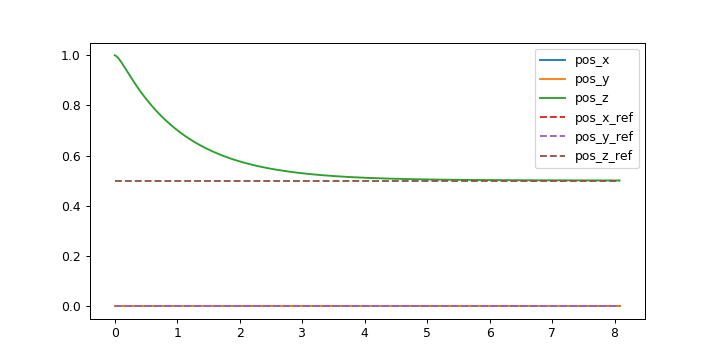

<IPython.core.display.Javascript object>


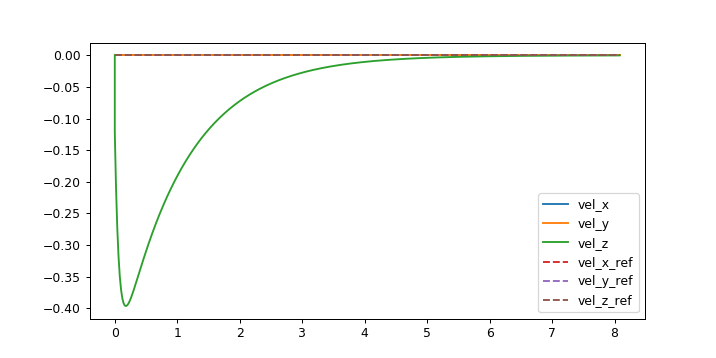

<IPython.core.display.Javascript object>


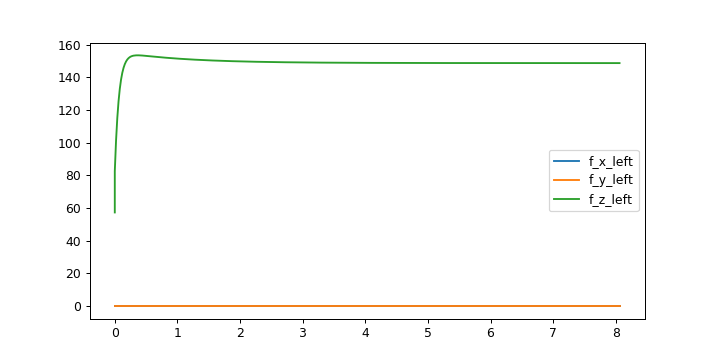

<IPython.core.display.Javascript object>


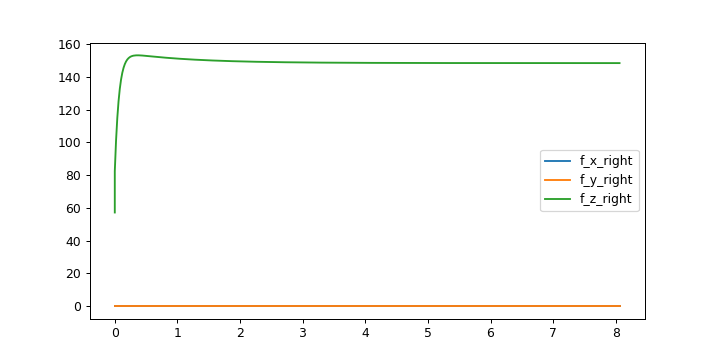

In [40]:
############################ MPC for full point mass model #######################################################

from casadi import *

dt = 1/50 # [s] (sampling time interval)
N = 100 # Prediction horizon Length

f_min = -1000 # Minimum Force 
f_max = 1000 # Maximum Force. Replace with max force in x, z, and z

phi = SX.sym('phi') # Orientation Euler Angle 1
theta = SX.sym('theta') # Orientation Euler Angle 2
psi = SX.sym('psi') # Orientatoin Euler Angle 3

omega_x = SX.sym('omega_x')
omega_y = SX.sym('omega_y')
omega_z = SX.sym('omega_z')

p_x = SX.sym('p_x') # position X
p_y = SX.sym('p_y') # position Y
p_z = SX.sym('p_z') # position Z

v_x = SX.sym('v_x') # velocity X
v_y = SX.sym('v_y') # velocity Y
v_z = SX.sym('v_z') # velocity Z

g_constant = SX.sym('g') # gravity state / constant (is augmented to allow state space form), might be seperated again for readability

states = [phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, g_constant]
n = len(states)

f_x_l = SX.sym('f_x_l') # Force in X on left foot
f_y_l = SX.sym('f_y_l') # Force in Y on left foot
f_z_l = SX.sym('f_z_l') # Force in Z on left foot

f_x_r = SX.sym('f_x_r') # Force in X on right foot
f_y_r = SX.sym('f_y_r') # Force in Y on right foot
f_z_r = SX.sym('f_z_r') # Force in Z on right foot

controls = [f_x_l, f_y_l, f_z_l, f_x_r, f_y_r, f_z_r]
m = len(controls)

U = SX.sym('U', m, N) # Control action matrix (that will be determined by the NLP solver)
X = SX.sym('X', n, N + 1) # State Matrix (that will also be determined by the NLP solver due to the chosen multiple-shooting method). The + 1 is for x0
P = SX.sym('P', n + n) # Parameter Matrix containing states and reference states. n + n to have n elements for the initial state and n elements for the reference state.

objective_function = 0 # expression for the objective function

# lbx = lower bounds on optimization variable(s)
# ubx = upper bounds on optimization variable(s)
# lbg = lower bounds on constraints vector (should also be a vector), for equality constraints, just set lbg=ubg=k, where k is the constraint value
# ubg = upper bounds on constraints vector (should also be a vector)

lbx = []
ubx = []
lbg = []
ubg = []

g = [] # Constraint vector (both equality and inequality)

g += [X[:,0] - P[0:n]] # equality constraint x0 (chosen by solver) - x0 (input as parameter by user) = 0

# POSSIBLE BUG:

lbg += [0] * n # n zeroes for equality constraints. These are to ensure solver and actual initial state are the same.
ubg += [0] * n # n zeroes for equality constraints. These are to ensure solver and actual initial state are the same.

Q = np.diag([100,100,100,100,100,100,100,100,100,100,100,100,100])

R = np.diag([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])

t = 0

x_t = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -9.81]

x_ref = [0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, -9.81]

# For now, the desired state is constant, when that will change, the average angle will have to be calculated from the time-varying state trajectory.
avg_psi = x_ref[2]

I_world = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]]) # Inertia in the world frame. See symbolic definiton with rotation matrix from body frame above.

# Location of the force vector being applied by the left foot.
r_x_left = 0.1
r_y_left = 0
r_z_left = 0

# Location of the force vector being applied by the right foot.
r_x_right = -0.1
r_y_right = 0
r_z_right = 0


# Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                  [r_z_left, 0, -r_x_left],
                                  [-r_y_left, r_x_left, 0]]) 
    
r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                   [r_z_right, 0, -r_x_right],
                                   [-r_y_right, r_x_right, 0]]) 

A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(avg_psi), math.sin(avg_psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(avg_psi), math.cos(avg_psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

B_c = np.block([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [I_world @ r_left_skew_symmetric, I_world @ r_right_skew_symmetric],
                [1/m_value, 0, 0, 1/m_value, 0, 0],
                [0, 1/m_value, 0, 0, 1/m_value, 0],
                [0, 0, 1/m_value, 0, 0, 1/m_value],
                [0, 0, 0, 0, 0, 0]])

A_d, B_d = discretize_ss(A_c, B_c, dt)

print("A_d shape:", A_d.shape)
print("B_d shape:", B_d.shape)

for i in range(0, N):
    #print("i:", i)
    
    state = X[:, i] # extract state at current time step
    control = U[:, i] # extract control input at current time step
    
    # Add the symbolic cost for each time step to the objective function 
    objective_function = objective_function + (state - P[n:]).T @ Q @ (state - P[n:]) + control.T @ R @ control
    
    #This is the equality constraint required for multiple shooting, so that the solver respects the system dynamics
    next_state = X[:, i+1]
    next_state_simulation = A_d @ state + B_d @ control
    #print("next_state_simulation:", next_state_simulation)
    #print("next state simulation type:", type(next_state_simulation))
    
    g += [next_state - next_state_simulation]
    
    lbg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state
    ubg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state

optimization_variables = [X.reshape((n * (N+1), 1)), U.reshape((m * N, 1))]

nlp = {'x':vertcat(*optimization_variables), 'f':objective_function, 'g':vertcat(*g), 'p':P}

opts = {}
opts["print_time"] = 0
#opts["expand"] = False
opts['ipopt'] = {"max_iter":2000, "print_level":0, "acceptable_tol":1e-8, "acceptable_obj_change_tol":1e-6}

solver = nlpsol('solver', 'ipopt', nlp, opts);

state_history = [x_t]
optimal_state_history = []
optimal_control_history = []
control_history = []
t_history = [t]

# Initialization values for solver. These should be filled with at least a linear interpolation between initial and desired state to improve performance.
# They are updated every iteration.

U_t = np.zeros((m, N))
X_t = np.tile(x_t, N+1)

simulation_time = 10 # [s]

iterations = 0

for i in range(0, n * (N+1) + m * N):
    
    # TODO: Add state and input constraints such as friction and robot limits or something like that
    if i < n * (N+1) - 1: # Loop is still inside the state decision variable region in the vector.
        lbx += [-inf]
        ubx += [inf]
    else: # Again, add friction contraints here.
        lbx += [f_min]
        ubx += [f_max]
    
while (abs(np.linalg.norm(np.array(x_t[3:6]).reshape(3,1) - np.array(x_ref[3:6]).reshape(3,1)))) > 0.001 and t < simulation_time and True:
    x0_solver = vertcat(*[X_t.reshape((n * (N+1), 1)), U_t.reshape((m * N, 1))])
    sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=vertcat(*[x_t, x_ref]))
    #print(sol['x'].shape)
    X_t = sol['x'][0: n * (N+1)]
    #print(X_t.shape)
    U_t = sol['x'][n * (N+1):]
    #print(U_t.shape)
    #print("X_t:", X_t)
    #print("U_t:", U_t)
    #print(sol['x'].shape)

    t_history.append(t)
    optimal_state_history.append(X_t)
    optimal_control_history.append(U_t)
    #print(U_t[0:m])
    x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ np.array(U_t[0:m]).reshape(m,1)
    x_t = DM(x_t)
    #print(x_t)
    
    #print(x_t)
    
    state_history.append(x_t)
    control_history.append(np.array(U_t[0:m]).reshape(m,1))
    
    #print("Distance to reference state:", x_t[0] - x_ref[0])

    t += dt
    iterations += 1
    
print("Final MPC iterations:", iterations)
print("Steady state error:", state_history[-1][0] - x_ref[0])
    
plt.rcParams['figure.figsize'] = [8, 4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in state_history],label="pos_x")
ax.plot(t_history, [x[4] for x in state_history],label="pos_y")
ax.plot(t_history, [x[5] for x in state_history],label="pos_z")

ax.plot(t_history, np.ones(len(t_history)) * x_ref[3], label="pos_x_ref", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * x_ref[4], label="pos_y_ref", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * x_ref[5], label="pos_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[9] for x in state_history],label="vel_x")
ax.plot(t_history, [x[10] for x in state_history],label="vel_y")
ax.plot(t_history, [x[11] for x in state_history],label="vel_z")

ax.plot(t_history, np.ones(len(t_history)) * x_ref[9], label="vel_x_ref", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * x_ref[10], label="vel_y_ref", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * x_ref[11], label="vel_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history[:-1], [x[0] for x in control_history], label="f_x_left")
ax.plot(t_history[:-1], [x[1] for x in control_history], label="f_y_left")
ax.plot(t_history[:-1], [x[2] for x in control_history], label="f_z_left")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history[:-1], [x[3] for x in control_history], label="f_x_right")
ax.plot(t_history[:-1], [x[4] for x in control_history], label="f_y_right")
ax.plot(t_history[:-1], [x[5] for x in control_history], label="f_z_right")

plt.legend()

In [7]:
def matrix_exponential(matrix, t, n, exponent):
    x_t = np.identity(n)
    for i in range(1, exponent):
        x_t = x_t + (matrix**i * t**i) / math.factorial(i)
        
    return x_t

In [8]:
def discretize_ss(A, B, dt):
    A_B = np.block([[A, B],
                [np.zeros((B.shape[1], A.shape[0])), np.zeros((B.shape[1], B.shape[1]))]])
    #print("A shape:", A.shape)
    #print("B shape:", B.shape)
    #print("A_B shape:", A_B.shape)

    eAt_d = matrix_exponential(A_B, t = dt, n=A_B.shape[0], exponent=60)

    A_d_temp = eAt_d[:A.shape[0], :A.shape[0]]

    B_d_temp = eAt_d[:B.shape[0], A.shape[0]:]

    return (A_d_temp, B_d_temp)

In [9]:
def step_discrete_system(A_param, B_param, x0_param, u_param, t_param):
    states_param = [x0_param]
    
    time_range = np.arange((t_param * (1/dt)))
    
    print("k is:", time_range)
    
    for k in time_range:
        states_param.append(A_param.dot(states_param[-1]) + B_param.dot(u_param))
        
    return states_param

In [11]:
state_trajectory = []

position = 0

for i in np.arange(0, 10, dt):
    vel_desired = 1
    position += vel_desired * dt
    state_trajectory.append(np.array([[position],
                                      [vel_desired],
                                      [-9.81]]))
    
x_ref = np.array(np.block(state_trajectory)).shape
    

plt.plot([x[0] for x in state_trajectory])
plt.plot([x[1] for x in state_trajectory])